# Modeling

---

## Importing Libraries and Loading Data

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
import catboost as cb

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers as tfl

import mlflow
from mlflow import MlflowClient

%matplotlib inline

In [2]:
df = pd.read_csv('../data/processed/sales_processed.csv')
list(df.columns)

['X1_sales_in_vol',
 'X2_sales_in_val',
 'X3_sales',
 'X4_turnover',
 'X5_value',
 'X1_sales_in_vol_disc',
 'X2_sales_in_val_disc',
 'X3_sales_disc',
 'X4_turnover_disc',
 'X5_value_disc',
 'X6_sign_AUCHAN',
 'X6_sign_CARREFOUR',
 'X6_sign_CARREFOUR MARKET',
 'X6_sign_CASINO',
 'X6_sign_CORA',
 'X6_sign_GEANT',
 'X6_sign_INTERMARCHE',
 'X6_sign_LECLERC',
 'X6_sign_MONOPRIX',
 'X6_sign_OTHERS',
 'X6_sign_SIMPLY MARKET',
 'X6_sign_SUPER U',
 'X7_feature_Feat',
 'X7_feature_No_Feat',
 'Y_display']

In [3]:
df['Y_display'] = (df['Y_display']=='Displ').astype(int)
df['Y_display'].value_counts()

Y_display
0    13000
1    12782
Name: count, dtype: int64

In [4]:
X, y = df.drop('Y_display', axis=1), df['Y_display']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

---

## Modeling

### Metrics

For this particular problem, we are interested in minimizing the number of false positives (or the risk), for this reason we will create two custom metrics from the confusion matrix.

$precision\_risk = \frac{FP}{FP + TN}$

$recall\_risk = \frac{FP}{FP + TP}$

In [15]:
def precision_risk(cm):
    return cm[0,1] / (cm[0,1] + cm[0,0])

def recall_risk(cm):
    return cm[0,1] / (cm[0,1] + cm[1,1])

def f1_risk(cm):
    return 2 * precision_risk(cm) * recall_risk(cm) / (precision_risk(cm) + recall_risk(cm))

def train_and_evaluate(model, X_train, X_test, y_train, y_test, show_train=True, show_report=True, show_cm=True):
    # train model
    model.fit(X_train, y_train)

    # evaluate on train set
    print('Train set:')
    y_pred_train = model.predict(X_train)
    cm_train = confusion_matrix(y_train, y_pred_train)
    print(f'Train Precision risk: {precision_risk(cm_train)}')
    print(f'Train Recall risk: {recall_risk(cm_train)}')
    print(f'Train F1 risk: {f1_risk(cm_train)}')
    print(classification_report(y_train, y_pred_train))
    ConfusionMatrixDisplay(confusion_matrix(y_train, y_pred_train)).plot()
    plt.show()
    
    # evaluate on test set
    print('Test set:')
    y_pred_test = model.predict(X_test)
    cm_test = confusion_matrix(y_test, y_pred_test)
    pr_risk, rc_risk, fo_risk = precision_risk(cm_test), recall_risk(cm_test), f1_risk(cm_test)
    print(f'Test Precision risk: {pr_risk}')
    print(f'Test Recall risk: {rc_risk}')
    print(f'Test F1 risk: {fo_risk}')
    print(classification_report(y_test, y_pred_test))
    ConfusionMatrixDisplay(cm_test).plot()
    plt.show()
    
    # return metrics for mlflow logging
    return pr_risk, rc_risk, fo_risk

### Models

We'll try the following models:
- Logistic Regression
  - With L1 regularization
  - With L2 regularization
  - PLS
- K Nearest Neighbors
- Non Linear SVM
- Decision Tree
- Random Forest
- Gradient Boosting
- Neural Network

In MLFlow, we will create a new experiment for each model, and we will log the following:
- Hyperparameters
- Metrics (precision_risk, recall_risk, f1_risk)
- Model

In [9]:
# separate continuous from discretized features
features = list(X.columns[:5]) + list(X.columns[10:])
features_disc = list(X.columns[5:])

In [32]:
mlflow.set_tracking_uri('http://127.0.0.1:8080')

### Logistic Regression

We'll start simple, then raise the complexity of each model.

In [33]:
mlflow.create_experiment('Logistc_Regression', tags={'mlflow.note.content': 'Models based on logistic regression'})
mlflow.set_experiment('Logistc_Regression')

<Experiment: artifact_location='mlflow-artifacts:/748874539335862975', creation_time=1706009157231, experiment_id='748874539335862975', last_update_time=1706009157231, lifecycle_stage='active', name='Logistc_Regression', tags={'mlflow.note.content': 'Models based on logistic regression'}>

Train set:
Train Precision risk: 0.11305014862402915
Train Recall risk: 0.15343571056741281
Train F1 risk: 0.1301827416772484
              precision    recall  f1-score   support

           0       0.71      0.89      0.79     10429
           1       0.85      0.64      0.73     10196

    accuracy                           0.76     20625
   macro avg       0.78      0.76      0.76     20625
weighted avg       0.78      0.76      0.76     20625



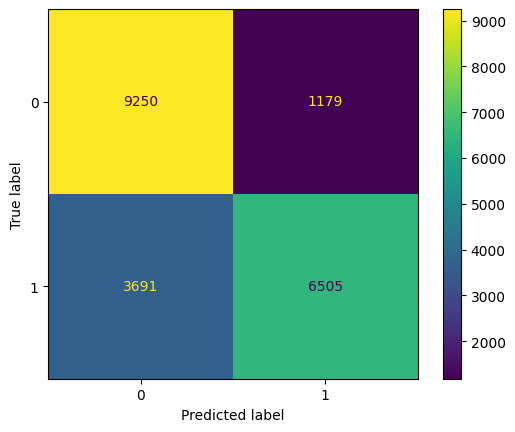

Test set:
Test Precision risk: 0.11901983663943991
Test Recall risk: 0.15315315315315314
Test F1 risk: 0.13394615889691397
              precision    recall  f1-score   support

           0       0.72      0.88      0.79      2571
           1       0.85      0.65      0.74      2586

    accuracy                           0.77      5157
   macro avg       0.78      0.77      0.76      5157
weighted avg       0.78      0.77      0.76      5157



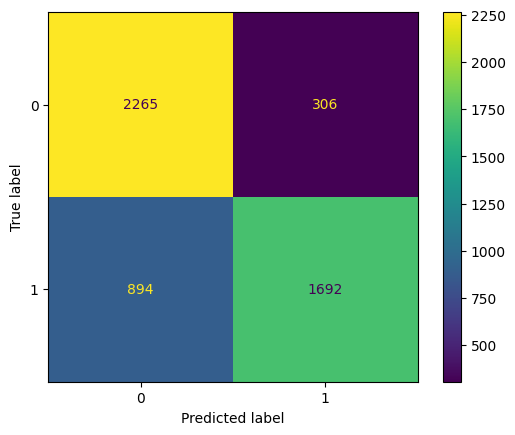

In [20]:
logreg_v1_params = {
    'random_state': 42
}
logreg_v1 = Pipeline([
    ('scaler', RobustScaler()),
    ('logreg', LogisticRegression(**logreg_v1_params))
])
pr_risk, rc_risk, fo_risk = train_and_evaluate(logreg_v1, X_train[features], X_test[features], y_train, y_test)

Our model doesn't overfit the data, we see a similar performance between the train and test set.  
15% of the positive predictions are missclassifier.

In [34]:
with mlflow.start_run(run_name='logreg_v1'):
    # log the parameters
    mlflow.log_params(logreg_v1_params)
    # log the metrics
    mlflow.log_metrics({'precision_risk': pr_risk, 'recall_risk': rc_risk, 'f1_risk': fo_risk})
    # set the tags
    mlflow.set_tags({'Model': 'Logistic Regression', 'Version': 'v1', 'mlflow.note.content': 'Logistic Regression using the default parameters on the continuous features'})
    # log the model
    mlflow.sklearn.log_model(sk_model=logreg_v1, artifact_path='lr', input_example=X_train[features], registered_model_name='logreg_v1')

/home/mnijadi/Projects/product-display-modeling/.venv/lib/python3.11/site-packages/mlflow/models/signature.py:369: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  output_schema = _infer_schema(prediction)
Successfully registered model 'logreg_v1'.
2024/01/23 12:27:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creatio

In [35]:
pd.DataFrame(logreg_v1.named_steps['logreg'].coef_, columns=features).T.sort_values(by=0, ascending=False)

,0
X7_feature_Feat,1.315092
X6_sign_CASINO,0.981777
X6_sign_GEANT,0.602481
X2_sales_in_val,0.372983
X5_value,0.285411
X1_sales_in_vol,0.228050
X6_sign_INTERMARCHE,0.110970
X6_sign_MONOPRIX,0.009174
X6_sign_CARREFOUR,0.007269
X6_sign_CARREFOUR MARKET,-0.115271


- Coefficients associated with the categorical feature `X7` have a higher magnitude.
- We saw from the histograms of the MDLPC bins that high values for `X3` are associated with higher chances of the positive class, meaning that the coefficient for `X3` should be positive. However, it is negative, this is because there is a high correlation between `X3`, `X1` and `X2`. The ponalization that is implemented in the logistic regression model by default does a good job in reducing the magnitude of the coefficients for the correlated features.

Train set:
Train Precision risk: 0.08581839102502636
Train Recall risk: 0.12789368390968847
Train F1 risk: 0.10271417914730016
              precision    recall  f1-score   support

           0       0.70      0.91      0.79     10429
           1       0.87      0.60      0.71     10196

    accuracy                           0.76     20625
   macro avg       0.79      0.76      0.75     20625
weighted avg       0.78      0.76      0.75     20625



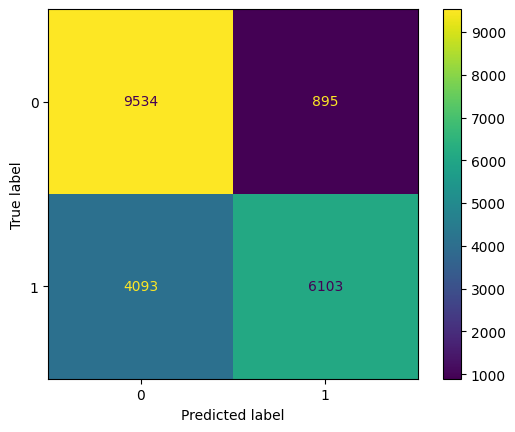

Test set:
Test Precision risk: 0.09684947491248541
Test Recall risk: 0.13495934959349593
Test F1 risk: 0.11277173913043477
              precision    recall  f1-score   support

           0       0.70      0.90      0.79      2571
           1       0.87      0.62      0.72      2586

    accuracy                           0.76      5157
   macro avg       0.78      0.76      0.75      5157
weighted avg       0.78      0.76      0.75      5157



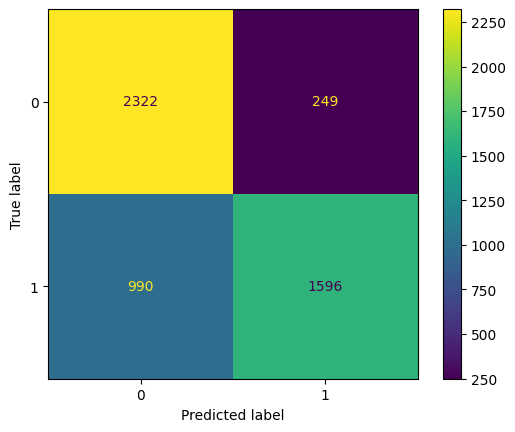

In [38]:
logreg_v2_params = {
    'penalty': 'l1',
    'solver': 'liblinear',
    'C': 0.01,
    'random_state': 42
}
logreg_v2 = Pipeline([
    ('scaler', RobustScaler()),
    ('logreg', LogisticRegression(**logreg_v2_params))
])
pr_risk, rc_risk, fo_risk = train_and_evaluate(logreg_v2, X_train[features], X_test[features], y_train, y_test)

Lasso regularization leads to a better performing model than the Ridge.  
The regularization parameter `C` is set to 1 by default, the lower its value, the lower the risk, but we can't afford to lower it too much since we risk to have a model that doesn't do any good at predicting the positive label.

In [42]:
with mlflow.start_run(run_name='logreg_v2'):
    # log the parameters
    mlflow.log_params(logreg_v2_params)
    # log the metrics
    mlflow.log_metrics({'precision_risk': pr_risk, 'recall_risk': rc_risk, 'f1_risk': fo_risk})
    # set the tags
    mlflow.set_tags({'Model': 'Logistic Regression', 'Version': 'v2', 'mlflow.note.content': 'Logistic Regression with L1 penalty on the continuous features'})
    # log the model
    mlflow.sklearn.log_model(sk_model=logreg_v2, artifact_path='lr', input_example=X_train[features], registered_model_name='logreg_v2')

/home/mnijadi/Projects/product-display-modeling/.venv/lib/python3.11/site-packages/mlflow/models/signature.py:369: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  output_schema = _infer_schema(prediction)
Registered model 'logreg_v2' already exists. Creating a new version of this model...
2024/01/23 12:38:03 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 s

In [40]:
pd.DataFrame(logreg_v2.named_steps['logreg'].coef_, columns=features).T.sort_values(by=0, ascending=False)

,0
X6_sign_CASINO,0.817528
X2_sales_in_val,0.287564
X5_value,0.221130
X1_sales_in_vol,0.115370
X7_feature_Feat,0.064060
X6_sign_INTERMARCHE,0.000000
X6_sign_SUPER U,0.000000
X6_sign_SIMPLY MARKET,0.000000
X6_sign_OTHERS,0.000000
X6_sign_MONOPRIX,0.000000


Most features associated with the `X6` feature are set to 0 by the Lasso regularization, the feature `X3` as well.

#### Using Discritized Variables 

Train set:
Train Precision risk: 0.14066545210470802
Train Recall risk: 0.18180691535506258
Train F1 risk: 0.15861174180992538
              precision    recall  f1-score   support

           0       0.71      0.86      0.78     10429
           1       0.82      0.65      0.72     10196

    accuracy                           0.75     20625
   macro avg       0.77      0.75      0.75     20625
weighted avg       0.77      0.75      0.75     20625



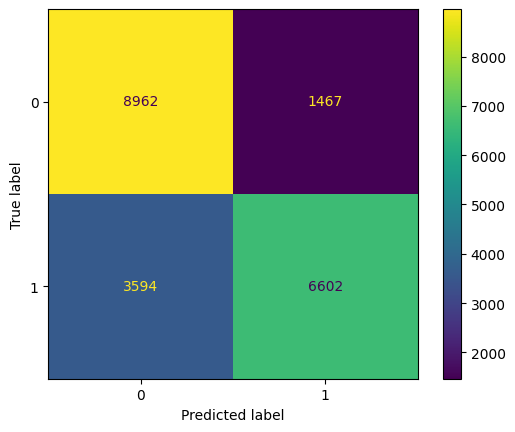

Test set:
Test Precision risk: 0.147024504084014
Test Recall risk: 0.1827852998065764
Test F1 risk: 0.16296615649924553
              precision    recall  f1-score   support

           0       0.71      0.85      0.77      2571
           1       0.82      0.65      0.73      2586

    accuracy                           0.75      5157
   macro avg       0.76      0.75      0.75      5157
weighted avg       0.76      0.75      0.75      5157



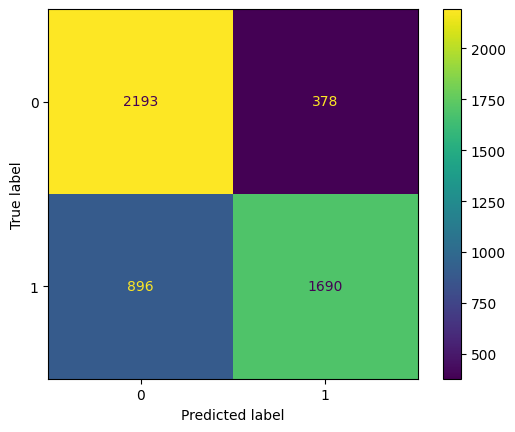

In [44]:
logreg_v3_parameters = {'random_state': 42}
logreg_v3 = LogisticRegression(**logreg_v3_parameters)
pr_risk, rc_risk, fo_risk = train_and_evaluate(logreg_v3, X_train[features_disc], X_test[features_disc], y_train, y_test)

This new version of the model using the discretized variables has an equal overall performance to the previous model (in terms of the accuracy of the model). However, given the evaluation criterion that we are more interested in, which is reducing the risk, this model has more false positives, and less false negatives, meaning that the previous model is better at reducing the risk.  
This behaviour can be changed easily using a different threshold for the predicted probabilities.  
Given this fact, we can say that it is possible to obtain a model that is so much simpler using the discretized features, with a similar performance and more generalization power.

#### Partial Least Squares Regression (PLSR)

We can also use PLSR to build a model that is more robust to multicollinearity.

############### n_component = 1 ###############
Train set:
              precision    recall  f1-score   support

           0       0.66      0.97      0.79     10358
           1       0.94      0.50      0.65     10267

    accuracy                           0.74     20625
   macro avg       0.80      0.73      0.72     20625
weighted avg       0.80      0.74      0.72     20625



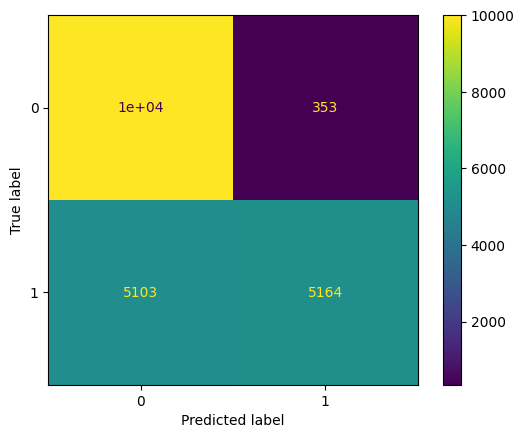

Test set:
              precision    recall  f1-score   support

           0       0.68      0.97      0.80      2642
           1       0.94      0.51      0.66      2515

    accuracy                           0.75      5157
   macro avg       0.81      0.74      0.73      5157
weighted avg       0.80      0.75      0.73      5157



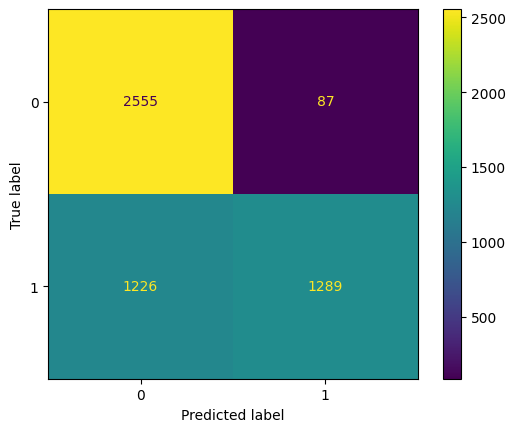

############### n_component = 2 ###############
Train set:
              precision    recall  f1-score   support

           0       0.66      0.94      0.77     10358
           1       0.89      0.51      0.65     10267

    accuracy                           0.73     20625
   macro avg       0.77      0.73      0.71     20625
weighted avg       0.77      0.73      0.71     20625



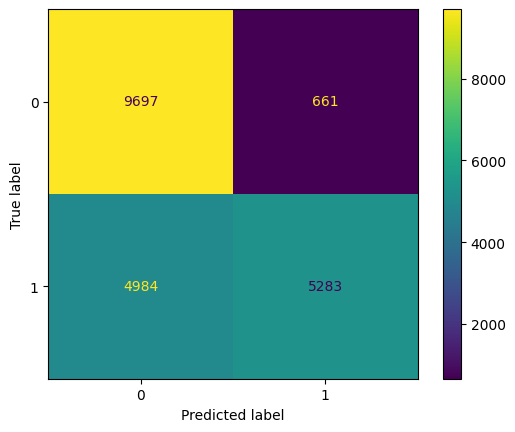

Test set:
              precision    recall  f1-score   support

           0       0.68      0.94      0.79      2642
           1       0.89      0.54      0.67      2515

    accuracy                           0.74      5157
   macro avg       0.79      0.74      0.73      5157
weighted avg       0.78      0.74      0.73      5157



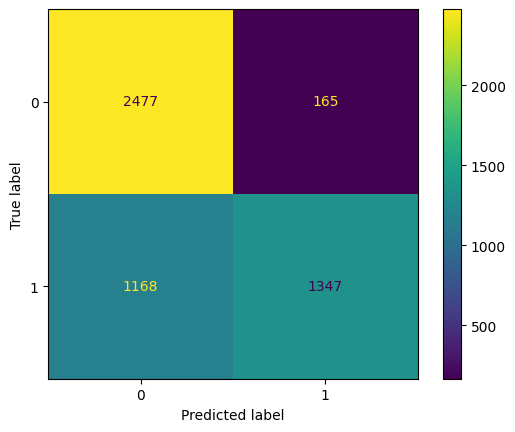

############### n_component = 3 ###############
Train set:
              precision    recall  f1-score   support

           0       0.68      0.91      0.78     10358
           1       0.86      0.57      0.68     10267

    accuracy                           0.74     20625
   macro avg       0.77      0.74      0.73     20625
weighted avg       0.77      0.74      0.73     20625



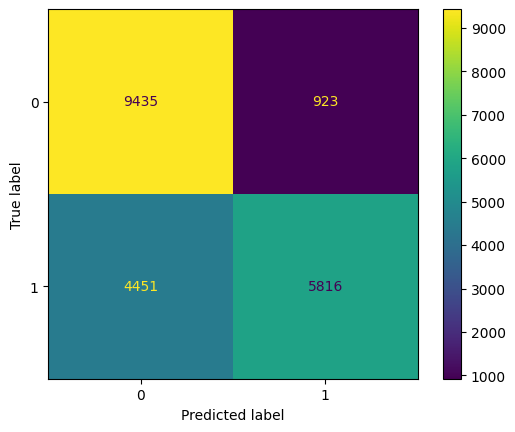

Test set:
              precision    recall  f1-score   support

           0       0.70      0.91      0.79      2642
           1       0.86      0.59      0.70      2515

    accuracy                           0.75      5157
   macro avg       0.78      0.75      0.74      5157
weighted avg       0.78      0.75      0.75      5157



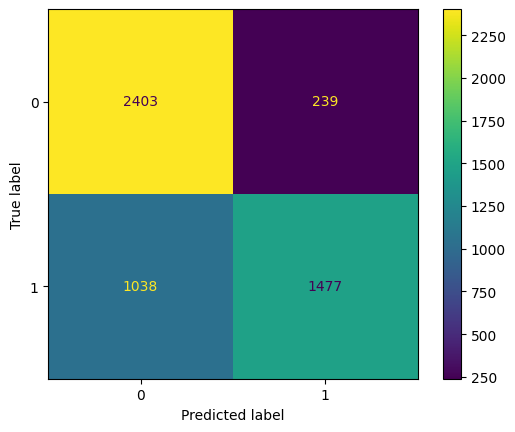

############### n_component = 4 ###############
Train set:
              precision    recall  f1-score   support

           0       0.69      0.90      0.78     10358
           1       0.85      0.59      0.70     10267

    accuracy                           0.75     20625
   macro avg       0.77      0.74      0.74     20625
weighted avg       0.77      0.75      0.74     20625



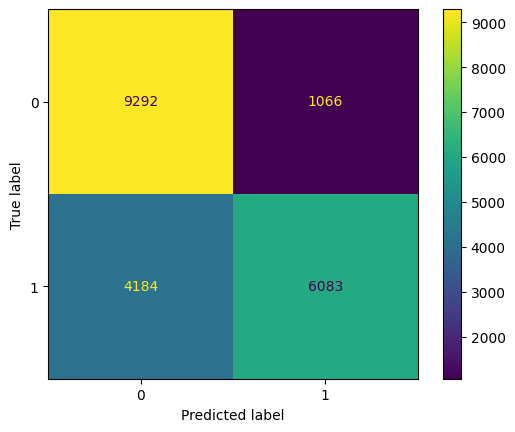

Test set:
              precision    recall  f1-score   support

           0       0.71      0.90      0.79      2642
           1       0.85      0.61      0.71      2515

    accuracy                           0.76      5157
   macro avg       0.78      0.75      0.75      5157
weighted avg       0.78      0.76      0.75      5157



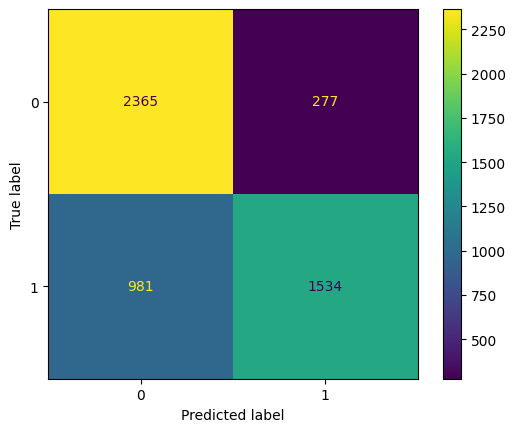

In [11]:
threshold = 0.5
for n_component in [1, 2, 3, 4]:
    print(f'############### n_component = {n_component} ###############')
    pls_v1 = Pipeline([
        ('scaler', RobustScaler()),
        ('pls', PLSRegression(n_components=n_component))
    ])
    pls_v1.fit(X_train, y_train)
    y_pred_train = (pls_v1.predict(X_train) > threshold).astype(int)
    y_pred_test = (pls_v1.predict(X_test) > threshold).astype(int)
    print('Train set:')
    print(classification_report(y_train, y_pred_train))
    ConfusionMatrixDisplay(confusion_matrix(y_train, y_pred_train)).plot()
    plt.show()
    print('Test set:')
    print(classification_report(y_test, y_pred_test))
    ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_test)).plot()
    plt.show()

First of all, there is no overfitting for any of these PLS models.  
We see that the risk of classifying a `No_Displ` product as `Displ` gets higher the more we increase the number of components. Meaning that we'd rather have a model with less components. (4 components lead to 277 fp and 981 fn, while 1 component leads to 87 fp and 1226 fn).  
However, we can't say that the model with 1 component is better, because it is actually not useful at all, since it is not able to classify any product as `Displ`.

### SVM

#### Using Continuous Variables

Train set:
              precision    recall  f1-score   support

           0       0.71      0.88      0.79     10358
           1       0.84      0.64      0.73     10267

    accuracy                           0.76     20625
   macro avg       0.77      0.76      0.76     20625
weighted avg       0.77      0.76      0.76     20625



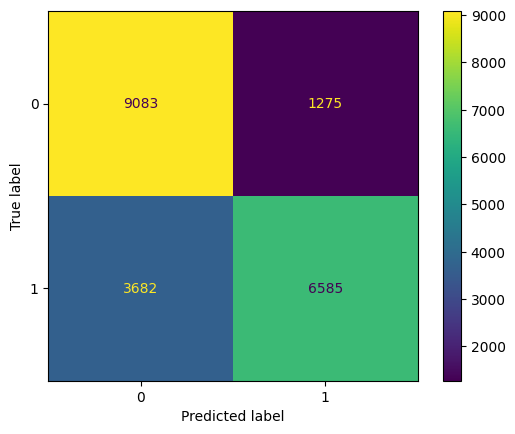

Test set:
              precision    recall  f1-score   support

           0       0.73      0.87      0.80      2642
           1       0.83      0.67      0.74      2515

    accuracy                           0.77      5157
   macro avg       0.78      0.77      0.77      5157
weighted avg       0.78      0.77      0.77      5157



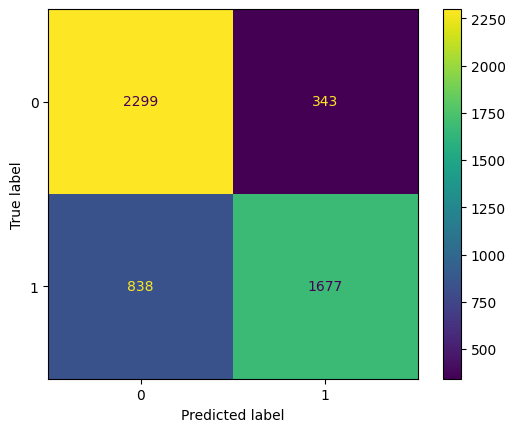

In [12]:
svm_v1 = Pipeline([
    ('scaler', RobustScaler()),
    ('svm', SVC())
])
train_and_evaluate(svm_v1, X_train, X_test, y_train, y_test)

The SVM model does a better job at reducing the risk, since we see a very low number of false positives. But at this point, we can just assign the negative class to every observation to have a model with 0 risk, but it would be useless. In our case here, we cannot rely on this model because it doesn't do good with he positive class, it has a high number of false negatives.

#### Using Discritized Variables

Train set:
              precision    recall  f1-score   support

           0       0.73      0.88      0.80     10358
           1       0.84      0.67      0.75     10267

    accuracy                           0.77     20625
   macro avg       0.79      0.77      0.77     20625
weighted avg       0.79      0.77      0.77     20625



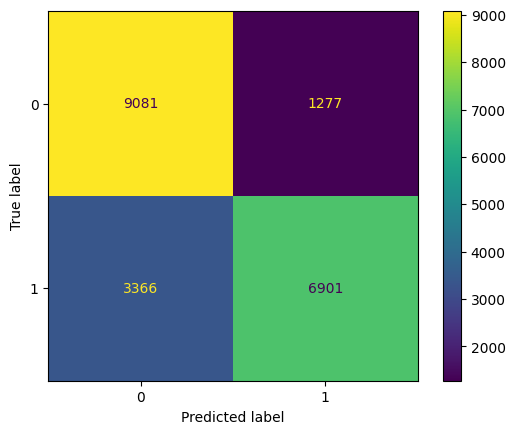

Test set:
              precision    recall  f1-score   support

           0       0.75      0.87      0.80      2642
           1       0.83      0.69      0.76      2515

    accuracy                           0.78      5157
   macro avg       0.79      0.78      0.78      5157
weighted avg       0.79      0.78      0.78      5157



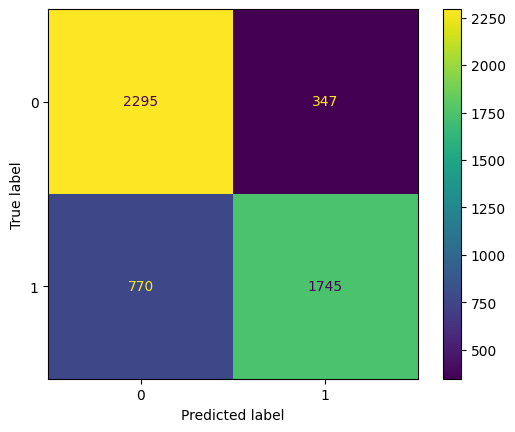

In [13]:
svm_v2 = SVC()
train_and_evaluate(svm_v2, X_train_discretized, X_test_discretized, y_train, y_test)

Using the discrete feature, the model becomes better working with the positive class, but it doesn't reduce the risk as much as the previous model (Logistic Regression).  
Again, we see that we can simplify the model a lot when working with the discretized features, and still have a similar performance (or slightly better).

#### Using PCA

PCA is a good method that creates new features that are uncorrelated, we can then build the SVM model on these new features.

Train set:
              precision    recall  f1-score   support

           0       0.63      0.91      0.74     10358
           1       0.84      0.45      0.59     10267

    accuracy                           0.68     20625
   macro avg       0.73      0.68      0.66     20625
weighted avg       0.73      0.68      0.66     20625



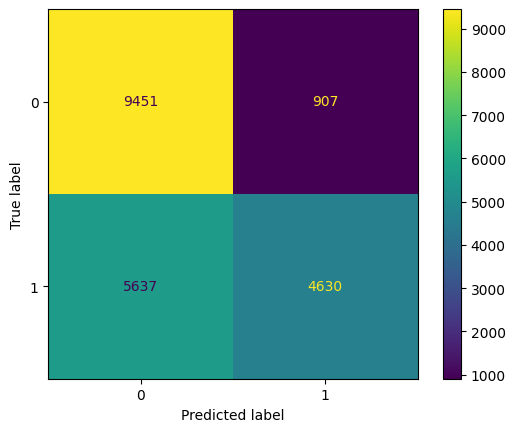

Test set:
              precision    recall  f1-score   support

           0       0.64      0.91      0.75      2642
           1       0.83      0.46      0.59      2515

    accuracy                           0.69      5157
   macro avg       0.73      0.68      0.67      5157
weighted avg       0.73      0.69      0.67      5157



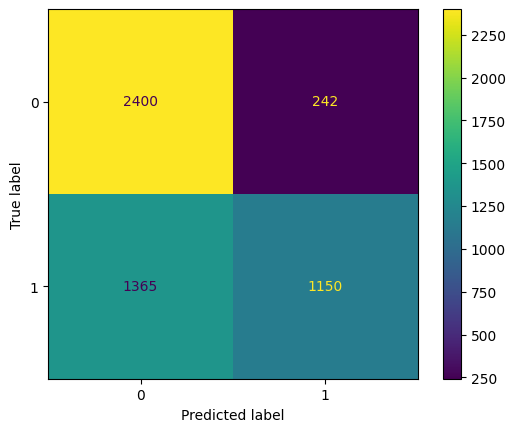

In [16]:
svm_v3 = Pipeline([
    ('scaler', RobustScaler()),
    ('pca', PCA(n_components=0.95)),
    ('svm', SVC())
])

train_and_evaluate(svm_v3, X_train, X_test, y_train, y_test)

We notice that eventhough these results seem good in terms of having a low risk, not only that the model is unable to classify the positive labels correctly, but it has an f1 score that is so much lower for both classes compared to the previous models.  
We also can't rely on the model because of its inefficiency, it takes so much time to train and predict.

### Decision Tree

The decision tree model doesn't need discretized features, because by default, it uses the Gini impurity criterion to split the continuous features.

Train set:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     10358
           1       1.00      0.99      1.00     10267

    accuracy                           1.00     20625
   macro avg       1.00      1.00      1.00     20625
weighted avg       1.00      1.00      1.00     20625



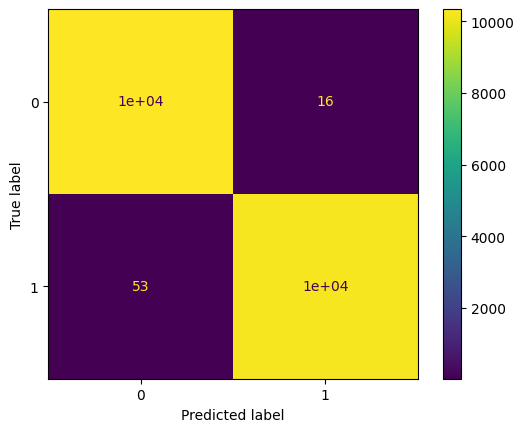

Test set:
              precision    recall  f1-score   support

           0       0.83      0.78      0.80      2642
           1       0.78      0.83      0.80      2515

    accuracy                           0.80      5157
   macro avg       0.80      0.80      0.80      5157
weighted avg       0.80      0.80      0.80      5157



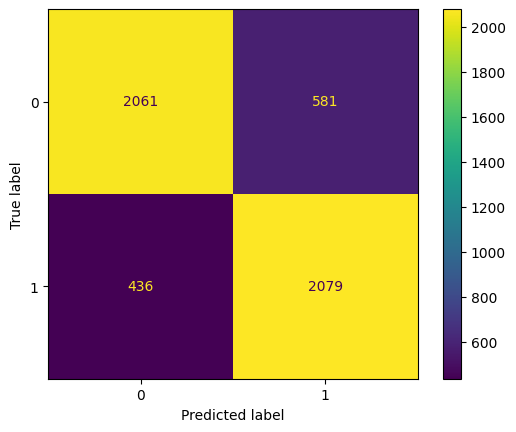

In [20]:
dt_v1 = DecisionTreeClassifier()
train_and_evaluate(dt_v1, X_train, X_test, y_train, y_test)

The decision tree model overfits the data, we will have to tune its hyperparameters to reduce the overfitting.

Train set:
              precision    recall  f1-score   support

           0       0.76      0.92      0.83     10358
           1       0.90      0.70      0.79     10267

    accuracy                           0.81     20625
   macro avg       0.83      0.81      0.81     20625
weighted avg       0.83      0.81      0.81     20625



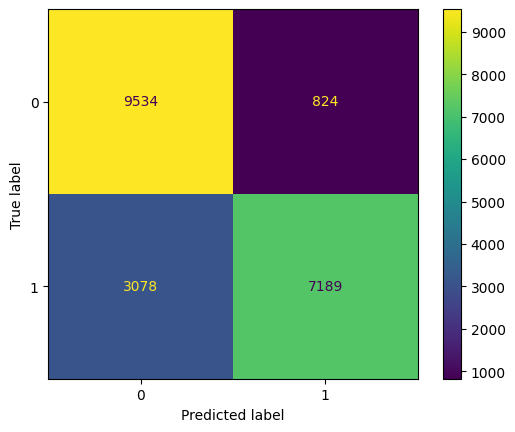

Test set:
              precision    recall  f1-score   support

           0       0.75      0.90      0.82      2642
           1       0.86      0.69      0.77      2515

    accuracy                           0.80      5157
   macro avg       0.81      0.79      0.79      5157
weighted avg       0.81      0.80      0.79      5157



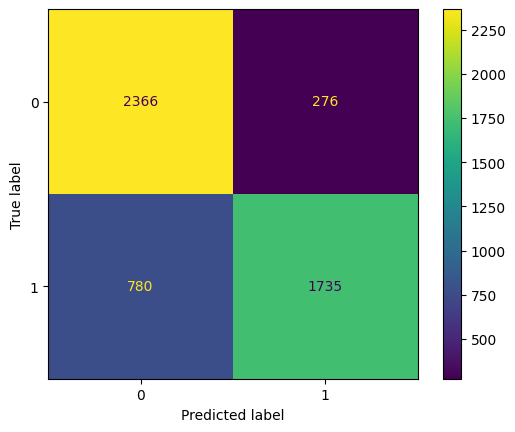

In [21]:
dt_v2 = DecisionTreeClassifier(max_depth=10)
train_and_evaluate(dt_v2, X_train, X_test, y_train, y_test)

We have been able to reduce overfitting only by controlling the depth of the tree. Our model is better than the previous ones, it works well with both classes, and it has a low risk.

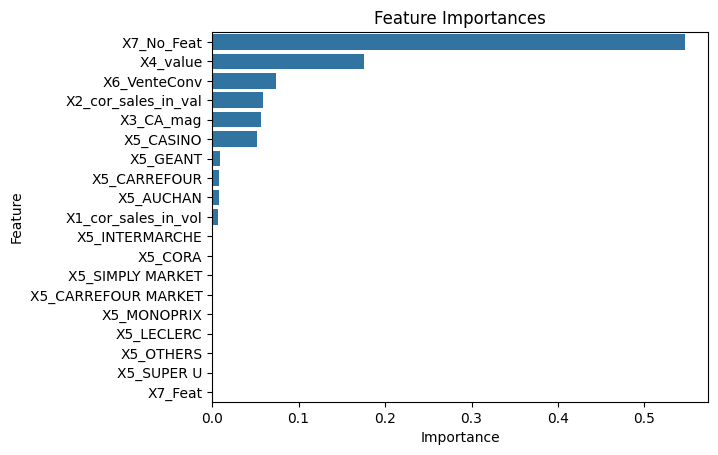

In [22]:
# plot feature importance
sns.barplot(
    data=pd.DataFrame(dt_v2.feature_importances_, columns=['Importance'], index=columns),
    x='Importance',
    y=columns,
    order=pd.DataFrame(dt_v2.feature_importances_, columns=['Importance'], index=columns).sort_values(by='Importance', ascending=False).index
)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

`X7` is the first feature used to construct the tree, this is a binary feature, that's why one category is the most important and the other is the least, because once the split is done, we do not need to use the other category anymore.

#### Discretizing numerical features using Decision Trees

In [41]:
cuts = []
for i in range(5):
    print(f'Discretizing feature: {columns[i]}')
    dt = DecisionTreeClassifier(max_depth=3)
    dt.fit(X_train[:, i].reshape(-1, 1), y_train)
    cut = sorted(dt.tree_.threshold)[-7:]
    print(cut)
    cuts.append(cut)

Discretizing feature: X1_cor_sales_in_vol
[4.509999990463257, 6.25, 7.309999942779541, 9.375, 15.195000171661377, 23.5, 46.5]
Discretizing feature: X2_cor_sales_in_val
[8.375, 33.545000076293945, 53.90500068664551, 83.25500106811523, 139.59500122070312, 192.9250030517578, 270.42999267578125]
Discretizing feature: X3_CA_mag
[7302.5, 7359.5, 18701.0, 28722.5, 109168.5, 109746.5, 115344.0]
Discretizing feature: X4_value
[3.5, 11.0, 29.0, 68.0, 78.0, 159.5, 171.5]
Discretizing feature: X6_VenteConv
[15.5, 141.27999877929688, 287.5, 379.0, 568.5, 926.5, 1510.0]


In [45]:
columns

Index(['X1_cor_sales_in_vol', 'X2_cor_sales_in_val', 'X3_CA_mag', 'X4_value',
       'X6_VenteConv', 'X5_AUCHAN', 'X5_CARREFOUR', 'X5_CARREFOUR MARKET',
       'X5_CASINO', 'X5_CORA', 'X5_GEANT', 'X5_INTERMARCHE', 'X5_LECLERC',
       'X5_MONOPRIX', 'X5_OTHERS', 'X5_SIMPLY MARKET', 'X5_SUPER U', 'X7_Feat',
       'X7_No_Feat'],
      dtype='object')

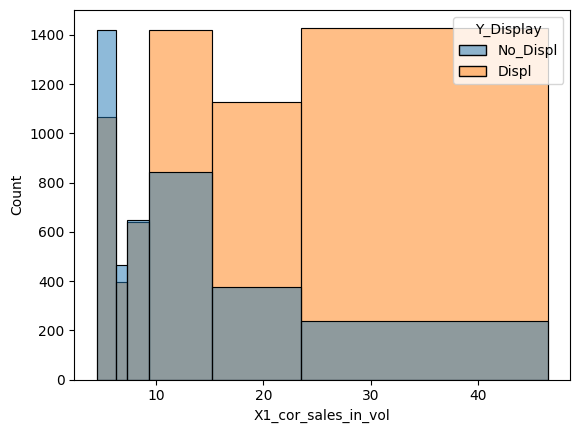

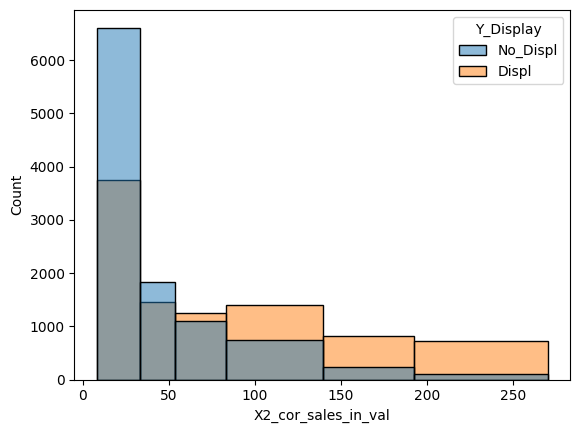

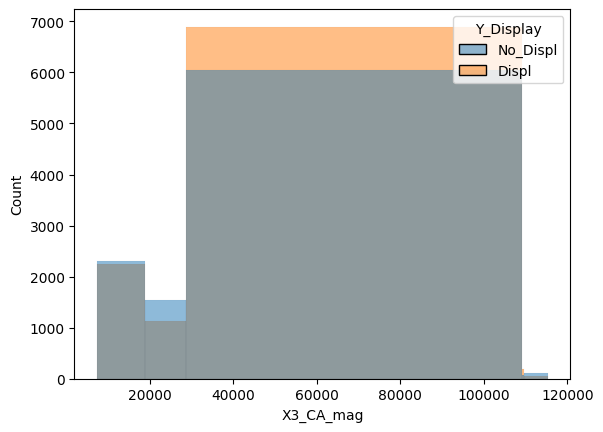

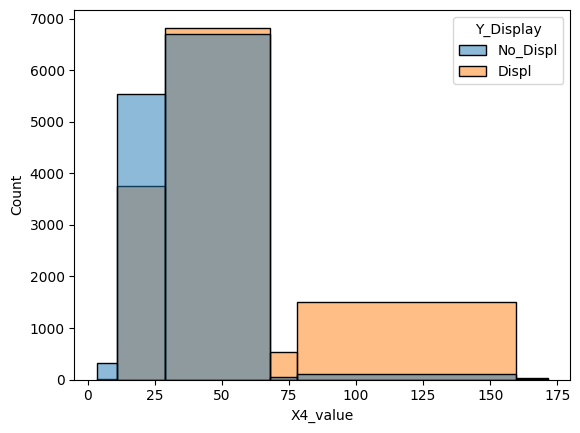

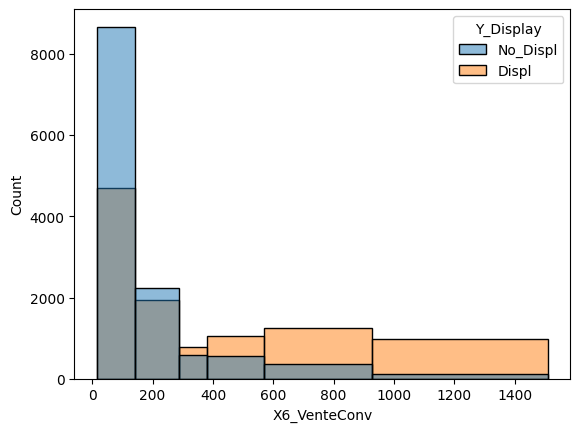

In [47]:
df = pd.read_csv('../data/processed/sales_cleaned.csv')
for index, feature in enumerate(columns[:5]):
    sns.histplot(data=df, x=feature, hue='Y_Display', bins=cuts[index])
    plt.show()

These new intervals are also great for separating features, but they can't be as good as the MDLPC ones, because in our case we are specifying the number of bins we want, and these bins might not be the best ones, we might need further splits, which is what the MDLPC algorithm does. However, we can clearly tell that the idea of splitting based on information gain is implemented for both algorithms.

### Random Forest

Train set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10358
           1       1.00      1.00      1.00     10267

    accuracy                           1.00     20625
   macro avg       1.00      1.00      1.00     20625
weighted avg       1.00      1.00      1.00     20625



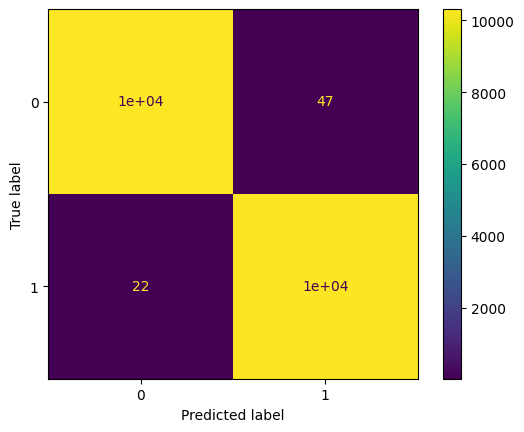

Test set:
              precision    recall  f1-score   support

           0       0.85      0.86      0.86      2642
           1       0.85      0.84      0.85      2515

    accuracy                           0.85      5157
   macro avg       0.85      0.85      0.85      5157
weighted avg       0.85      0.85      0.85      5157



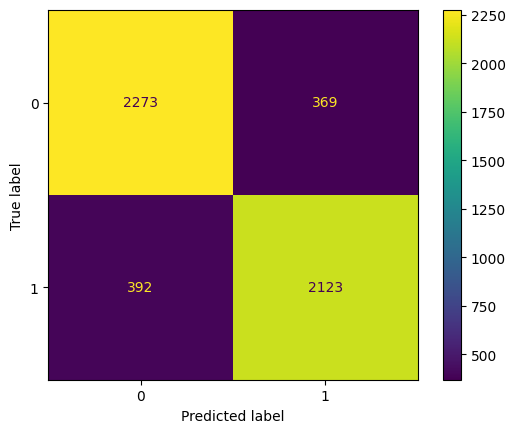

In [48]:
rf_v1 = RandomForestClassifier()
train_and_evaluate(rf_v1, X_train, X_test, y_train, y_test)

Bad overfitting !!!

Train set:
              precision    recall  f1-score   support

           0       0.75      0.92      0.83     10358
           1       0.90      0.69      0.78     10267

    accuracy                           0.81     20625
   macro avg       0.83      0.81      0.81     20625
weighted avg       0.82      0.81      0.81     20625



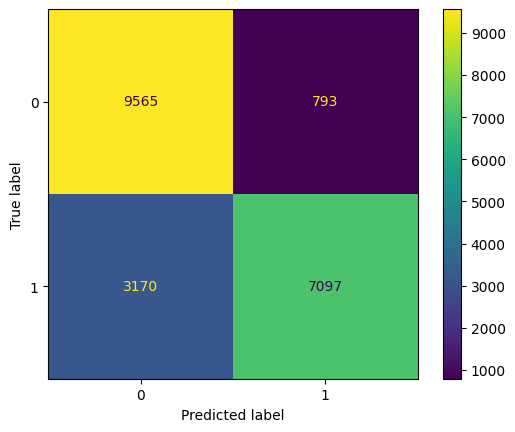

Test set:
              precision    recall  f1-score   support

           0       0.76      0.90      0.82      2642
           1       0.87      0.70      0.78      2515

    accuracy                           0.80      5157
   macro avg       0.81      0.80      0.80      5157
weighted avg       0.81      0.80      0.80      5157



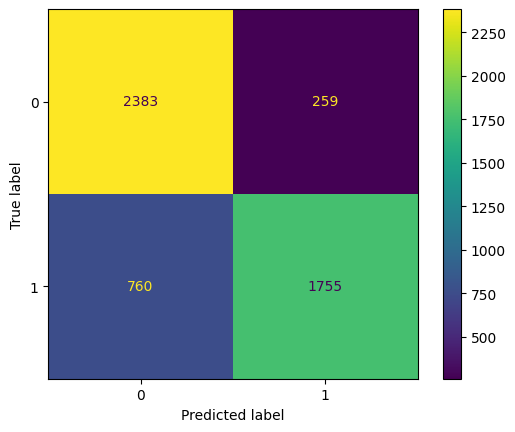

In [49]:
rf_v2 = RandomForestClassifier(max_depth=10)
train_and_evaluate(rf_v2, X_train, X_test, y_train, y_test)

In [ ]:
train_and_evaluate(RandomForestClassifier(max_depth=10), X_train, X_test, y_train, y_test)

Compared to the Decision Tree model, the Random Forest model does a better job at reducing the overfitting, and it reduces both the risk and error.

### Gradient Boosting using XGBoost

Train set:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89     10358
           1       0.92      0.85      0.88     10267

    accuracy                           0.89     20625
   macro avg       0.89      0.89      0.89     20625
weighted avg       0.89      0.89      0.89     20625



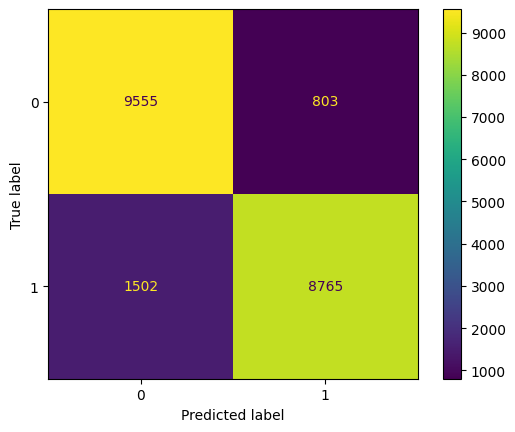

Test set:
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      2642
           1       0.85      0.81      0.83      2515

    accuracy                           0.84      5157
   macro avg       0.84      0.84      0.84      5157
weighted avg       0.84      0.84      0.84      5157



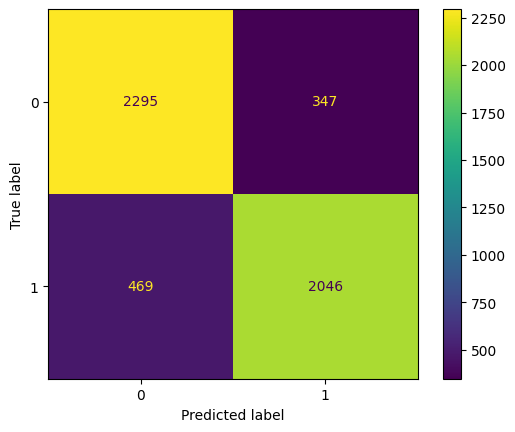

In [50]:
xgb_v1 = xgb.XGBClassifier()
train_and_evaluate(xgb_v1, X_train, X_test, y_train, y_test)

It's normal for these models to overfit the data, since these models learn very complex functions and representations of the data. That's why we will always have to tune their hyperparameters.  
The XGBoost model however, does't overfit as much as the random forest, which is a good sign.

In [51]:
# define the parameter grid
param_grid = {
    'n_estimators': [150, 200, 300],
    'max_depth': [5, 7, 10],
    'learning_rate': [1, 0.1, 0.01],
    'reg_lambda': [1, 0.1, 0.01],
    'reg_alpha': [1, 0.1, 0.01],
    'colsample_bytree': [0.8, 0.9, 1]
}

xgb_v2 = xgb.XGBClassifier()

# Create the GridSearchCV object
grid_search = RandomizedSearchCV(estimator=xgb_v2, param_distributions=param_grid, scoring='f1', n_iter=30, cv=3, n_jobs=-1, verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


Best Parameters:  {'reg_lambda': 0.01, 'reg_alpha': 0.01, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 1}
Best Score:  0.83641586329342


Train set:
              precision    recall  f1-score   support

           0       0.79      0.94      0.86     10358
           1       0.93      0.75      0.83     10267

    accuracy                           0.85     20625
   macro avg       0.86      0.85      0.85     20625
weighted avg       0.86      0.85      0.85     20625



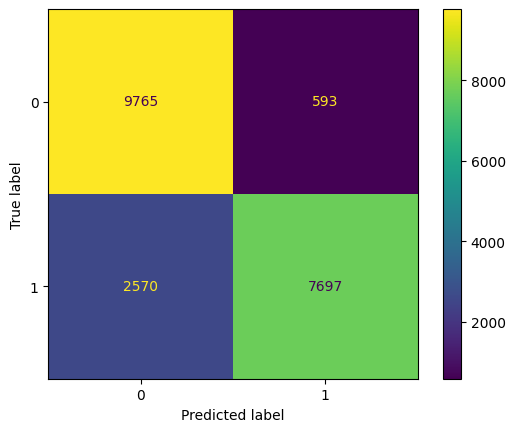

Test set:
              precision    recall  f1-score   support

           0       0.78      0.91      0.84      2642
           1       0.88      0.73      0.80      2515

    accuracy                           0.82      5157
   macro avg       0.83      0.82      0.82      5157
weighted avg       0.83      0.82      0.82      5157



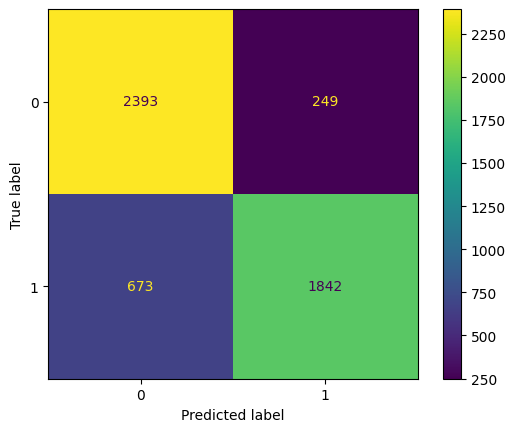

In [55]:
xgb_v2 = xgb.XGBClassifier(n_estimators=300, max_depth=10, learning_rate=0.01, reg_alpha=0.01, reg_lambda=0.01, colsample_bytree=0.8)
train_and_evaluate(xgb_v2, X_train, X_test, y_train, y_test)

After a few rounds of hyperparameter tuning, we were able to reduce the overfitting and have a model that is better at reducing the risk, while doing a good job at reducing the error as well.

## Conclusion

After applying all of these models, we can conclude that the best model is the Gradient Boosting model using XGBoost, as it has the lowest risk (249 FP), and the lowest error (673 FN).